# Generating Images with Diffusion 

* **Content Creator:** Jordan Matelsky
* **Content Reviewers:** Konrad Kording, Lyle Ungar

> **Before we get started: This notebook will use a new feedback technique we're testing. Please let us know what you think!**

## Introduction 

Unless you've been living under a rock, you've probably seen some pretty extraordinary generative AI in the past year. Among the most impressive is *stable diffusion*, an architecture that can generate images that are indistinguishable from "real" images. In this notebook, we'll take a look at how stable diffusion works, and see why it's so powerful. 

## Why aren't we covering GANs?

Generative adversarial networks (GANs) were the state-of-the-art for AI-generated images for a long time, but they have some serious drawbacks. If you've ever trained a network before and then retrained it only to get completely different performance, then you know how fragile some network architectures can be. Because GANs involve training a generator and a discriminator network in parallel, they're notoriously unstable, and can easily get stuck with one model "winning" over the other. They can also be difficult to steer in order to tailor the outputs — something we didn't realize as a community until we saw how overwhelmingly EASY it is to steer newer architectures, like stable diffusion. 

Originally we weren't even going to mention them in the course, but your beloved TA Jordan has a soft-spot for GANs since they were the first "big boy" networks he ever trained. So here you go, GANs — this paragraph is an ode to you. Now, onward to better and more stable things!

## GPU Runtime!

We won't build terribly large models today, but you WILL want to use a GPU runtime. If you're using Colab, you can change the runtime type in the menu above. If you're using Jupyter, you can use the `nvidia-smi` command to check if you have a GPU available.

## Today's Gameplan

- Understand dimensionality-reduction as a denoiser
- Learn how latent diffusion models work, and what the difference is between stable diffusion and latent diffusion
- Build our own simple latent-diffusion toy from scratch so we can touch its guts!


In [2]:
# !pip3 install matplotlib scikit-image numpy torch torchvision tqdm pytorch_lightning scikit-learn

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

## What is diffusion?

Place a massless particle at a point in space, and then repeatedly add or subtract a random small amount to its position, sampling $d \sim \mathcal{N}(0, 1)$. The particle will follow the laws of [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion). (Fun fact that will make you fun to talk to at parties: Before Einstein worked on relativity, he studied [the physics of diffusion](https://en.wikipedia.org/wiki/Brownian_motion#Einstein's_theory).)

Instead of moving a particle in 3D (and sampling $(d_x, d_y, d_z)$), we can move a particle in 784 dimensions. (Bear with me for a second.) Let's start at the origin, and see what happens over time:

In [95]:
# Feel free to play with hyperparameters! Note hyperparameters may be hardware-dependent.
BATCH_SIZE = 8

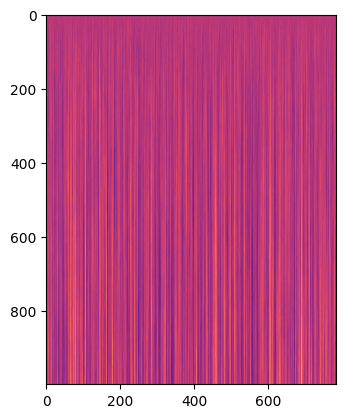

In [96]:
dim = 784
iters = 1000
all_vecs = np.zeros((iters, dim))
for i in range(1, iters):
    vec = np.random.normal(loc=0, scale=1, size=dim)
    all_vecs[i] = all_vecs[i-1] + vec

plt.imshow(all_vecs, cmap='magma')

Pretty! But what does it mean? Well, we can think of each dimension as a pixel in an image. So, if we start at the origin, and then diffuse one pixel/dimension at a time, we can "diffuse" an entire image. (Note that in this example, we diffuse each pixel independently!) In this interpretation, there is no meaning to the shape of the image; you can imagine it as a reshaped vector, that just happens to be a rectangle for visualization purposes.

Let's try it, but instead of starting at the origin, we're going to start at a specially chosen point in the space — specifically, the point that corresponds to this picture of a cat:

Text(0.5, 0.98, 'The great mystery of the disappearing cat')

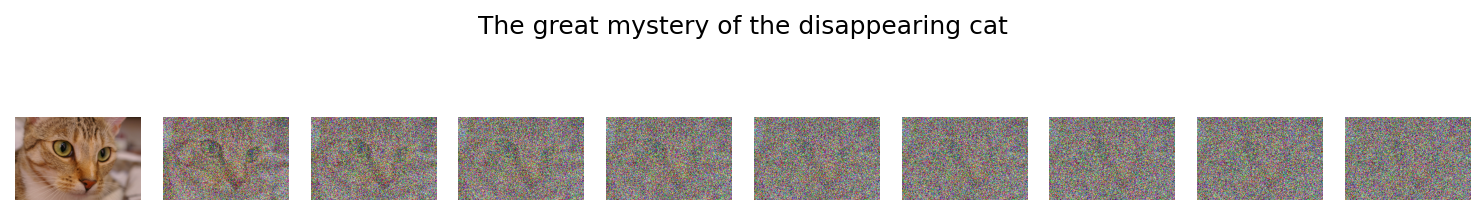

In [5]:
import matplotlib.pyplot as plt
from skimage import data

iters = 10
plt.subplots(1, iters, figsize=(10, 2), dpi=150)
plt.subplot(1, iters, 1)
last_img = data.cat().astype(np.float64)
plt.imshow(last_img / 255)
plt.axis('off')
plt.tight_layout()
for i in range(2, iters+1):
    plt.subplot(1, iters, i)
    last_img += np.random.normal(loc=0, scale=255, size=last_img.shape)
    plt.imshow(np.clip(last_img, 0, 255) / 255)
    plt.axis('off')
    plt.tight_layout()
plt.suptitle("The great mystery of the disappearing cat")

The image on the left is the original image, and the images on the right are the original image with random noise cumulatively added to it. 

**The main idea of a diffusion model is to "learn" the inversion of this process**, so that given the image on the far right, we can incrementally de-noise it to get back to the image on the left. Of course, _actually_ inverting this process is a hard (likely impossible!) task.

Let's look at how we might go about performing this denoising process. Can you think of any operations we've done in the past that had the effect of denoising images?

## Dimensionality Reduction Can Be a Denoising Process

One way to denoise an image is to reduce its dimensionality using a technique that preserves "important" information and disregards "unimportant" information. For example, we can use a [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) to reduce the dimensionality of an image. Let's try it out:

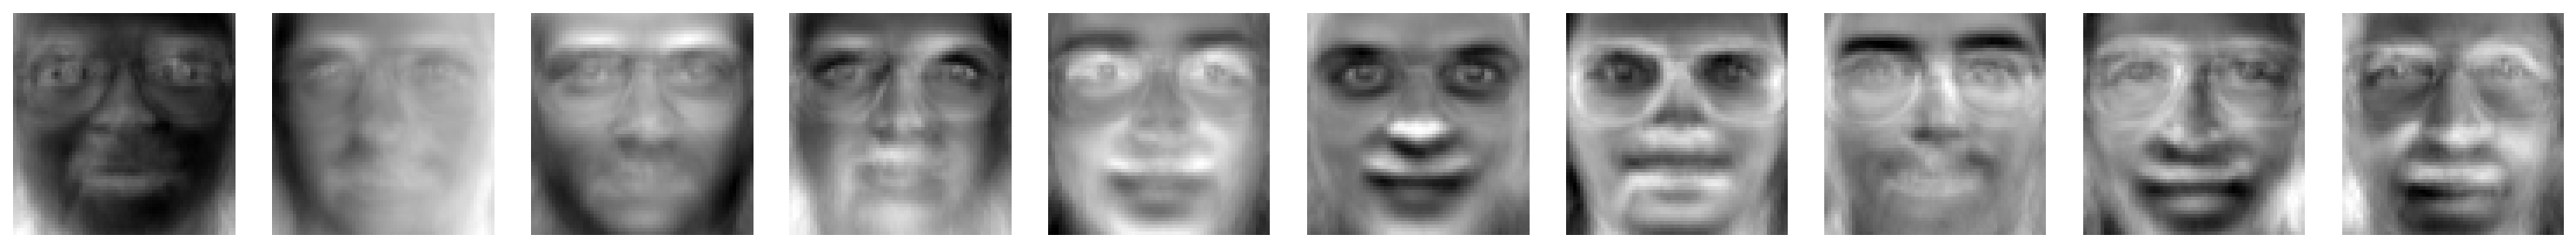

In [6]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_olivetti_faces

# Load the faces data from the LFW dataset
faces = fetch_olivetti_faces()
X = faces.data

# Create a PCA model with 100 components
pca = PCA(n_components=100)
pca.fit(X)

# Project the data onto the first two principal components
X_pca = pca.transform(X)

# Plot the first 10 eigenfaces
plt.subplots(1, 10, figsize=(20, 2), dpi=150)
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(pca.components_[i].reshape(64, 64), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()


In the above example, we took the principal components of the face dataset distribution and used them to reduce the amount of information we need to store about each face. For example, instead of storing the whole image, we can now store (1) the components, and (2) just 100 measly scalars, and still get a pretty good approximation of the original image. And because PCA chooses which components are the most important to the structure of the image, it definitionally throws away "noise" — the dimensions of the image that don't matter much to its overall structure.

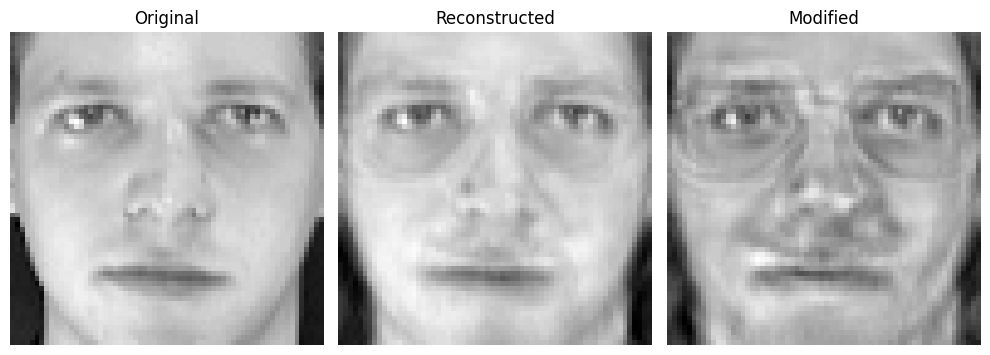

In [7]:
# Plot the first face from the dataset as the original image,
# the first reconstructed face,
# and a modified version of the face by manipulating the "latent" vector
plt.subplots(1, 3, figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(X[0].reshape(64, 64), cmap="gray")
plt.axis("off")
plt.title("Original")
plt.subplot(1, 3, 2)
plt.imshow(pca.inverse_transform(X_pca)[0].reshape(64, 64), cmap="gray")
plt.axis("off")
plt.title("Reconstructed")
# Synthetic!
plt.subplot(1, 3, 3)
plt.imshow(
    pca.inverse_transform(X_pca + np.random.normal(0, 0.5, size=X_pca.shape))[0].reshape(
        64, 64
    ),
    cmap="gray",
)
plt.axis("off")
plt.title("Modified")
plt.tight_layout()
plt.show()


Here, we plot three faces: First, a face from the dataset, then the closest we can get to that face using only the parameters stored in the model (i.e., the principal components), and finally, **a face that we've generated using a made-up vector.** 

That's a neat trick... let's do it again, using a totally made up vector. To be cheeky, let's use the 25-character string 

> this person doesn't exist

repeated four times, in ascii:

```
116 104 105 115 32 112 101 ...
T   H   I   S   _   P   E  ...
```

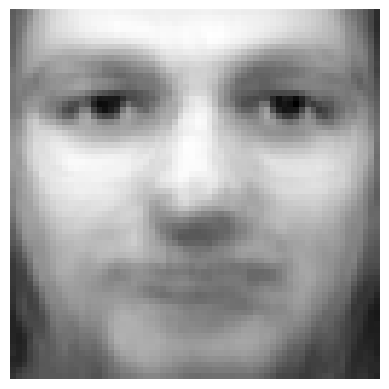

In [8]:
my_vector = np.array([
    116,104,105,115,32,112,101,114,115,111,110,32,100,111,101,115,110,39,116,32,101,120,105,115,116,
] * 4)

# Reverse the PCA transformation on this made-up vector
# (downscaled to get things into a reasonable range)
reconstructed = pca.inverse_transform([my_vector * 0.001])

# Plot the reconstructed face
plt.imshow(reconstructed.reshape(64, 64), cmap="gray")
plt.axis("off")
plt.show()

**Quiz time! We just boldly declared that PCA can be thought of as a denoising model. What are some reasons why we couldn't use PCA as our denoiser in the latent diffusion model?**

Hint: ChatGPT doesn't know about stable diffusion yet, so you're on your own here!


In [9]:
why_pca_isnt_a_good_denoiser = "" #@param {type:"string"}

## Neural denoising

There are some clear disadvantages to PCA as a denoiser, chief among them that it is a linear model. This means that it can only learn to denoise images by performing linear combinations of the principal components. This is a pretty big limitation, and it's one we can overcome by using a neural network instead of a linear model.

There are a few architectures that we could use to denoise images using the same dimensionality-reduction trick as PCA:

In [10]:
# Some settings for our neural networks:

import pytorch_lightning as pl
from pytorch_lightning import Trainer

IMG_SIZE = 64
IMG_SIZE_PROD = IMG_SIZE * IMG_SIZE
IMG_CHANNELS = 1
CHOKEPOINT_SIZE = 256


### 1: Dimensionality Reduction with Autoencoders

We can also use an autoencoder to reduce the dimensionality of an image. An autoencoder is a neural network that takes an image as input, and then tries to reconstruct that same image as output. The network is trained to minimize the reconstruction error, which is the difference between the input and the output. Seems easy, right? The tricky part is that the network has to move all of the data through a chokepoint; a layer with very few units. This chokepoint layer, and the network that leads up to it, is called the **encoder**. The network that leads away from the chokepoint is called the **decoder**.

In the example below, we'll write a very simple autoencoder for the face dataset. The encoder will take an image as input, and then output a vector of length 100. The decoder will take that vector as input, and then output an image. The network will be trained to minimize the reconstruction error, which is the difference between the input image and the output image.

In [97]:
# Use PyTorch Lightning to train a simple autoencoder.
# Some code borrowed from https://pytorch-lightning.readthedocs.io/en/latest/model/train_model_basic.html


class Encoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(
            IMG_CHANNELS, 32, kernel_size=3, stride=2, padding=1
        )
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        # Linear:
        self.fc1 = torch.nn.Linear(128 * 8 * 8, 512)
        self.fc2 = torch.nn.Linear(512, CHOKEPOINT_SIZE)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class Decoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # unlinear:
        self.fc1 = torch.nn.Linear(CHOKEPOINT_SIZE, 512)
        self.fc2 = torch.nn.Linear(512, 128 * 8 * 8)
        # unflatten:
        self.conv1 = torch.nn.ConvTranspose2d(
            128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.conv2 = torch.nn.ConvTranspose2d(
            64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.conv3 = torch.nn.ConvTranspose2d(
            32, IMG_CHANNELS, kernel_size=3, stride=2, padding=1, output_padding=1
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 128, 8, 8)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x


class LitAutoEncoder(pl.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
        enc = self.encoder(x)
        x_hat = self.decoder(enc)
        loss = F.mse_loss(x_hat, x)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-4)
        return optimizer


faces = fetch_olivetti_faces()

dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(faces.data).float(), torch.from_numpy(faces.target).long()
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


ValueError: num_workers option should be non-negative; use num_workers=0 to disable multiprocessing.

In [98]:
autoencoder = LitAutoEncoder(Encoder(), Decoder())
trainer = pl.Trainer(max_epochs=50, log_every_n_steps=20, accelerator="gpu" if torch.cuda.is_available() else None, devices=1 if torch.cuda.is_available() else None)
trainer.fit(model=autoencoder, train_dataloaders=dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 4.4 M 
1 | decoder | Decoder | 4.4 M 
------------------------------------
8.8 M     Trainable params
0         Non-trainable params
8.8 M     Total params
35.382    Total estimated model params size (MB)
/home/jordan/projects/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The da

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


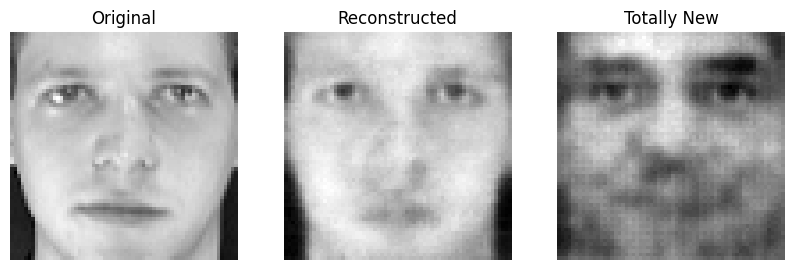

In [13]:
# Plot the first face from the dataset as the original image,
# the first reconstructed face,
# and a modified version of the face by manipulating the "latent" vector
plt.subplots(1, 3, figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(faces.data[0].reshape(64, 64), cmap="gray")
plt.axis("off")
plt.title("Original")
plt.subplot(1, 3, 2)
# Reconstruct the first face from the dataset:
latent = autoencoder.encoder(torch.from_numpy(faces.data[0].reshape(1, 1, 64, 64)).float())
reconstructed = autoencoder.decoder(latent)
plt.imshow(reconstructed.detach().numpy().reshape(64, 64), cmap="gray")

plt.axis("off")
plt.title("Reconstructed")
plt.subplot(1, 3, 3)
# A completely made-up face, with a random latent:
latent_new = torch.randn(1, CHOKEPOINT_SIZE)
reconstructed_new = autoencoder.decoder(latent_new)
plt.imshow(reconstructed_new.detach().numpy().reshape(64, 64), cmap="gray")
plt.axis("off")
plt.title("Totally New")
plt.show()

...alright, I mean... they're not the *prettiest* looking faces. But we're able to reconstruct a face surprisingly well, considering that ALL we're using is random numbers and the weights of our model. 

Try experimenting with the number of units in the chokepoint layer, the learning rate, the batch size... see if you can get better results! Can you find parameters that convince yourself that the reconstructed face in panel 2 is "just as good" as the original face in panel 1?

### 2: Dimensionality Reduction with a U-Net

A U-net neural network is another architecture that "downsamples" an image into a lower dimensional latent representation, and then "upsamples" it back to the original image. The network is trained to minimize the reconstruction error, just like the autoencoder. 

The main difference is that the U-net architecture "shares" information between the encoder and the decoder. This has some advantages and disadvantages. The main advantage is that U-nets' decoders get more of the original input's "global" information, because some of the information reaching the decoder is preserved from the encoder. The main _disadvantage_, as far as we're concerned, is that because of these skip connections, we can't really inject a latent into the chokepoint of the U-net, because we'd also need to invent realistic information for the skip connections. And unlike the autoencoder, we can't just use random numbers for the skip connections, because the skip connections are supposed to be meaningful global information about the input:

![A comparison of U Nets and Autoencoders](https://user-images.githubusercontent.com/693511/216820060-44c33768-2e98-48af-b746-046046681cf7.png)

So unfortunately, it's much harder to use a U-net to create new synthetic outputs. But it's still a very powerful denoiser, so let's review the three tools we have so far:

* PCA: An okay denoiser, but is "merely" a linear model.
* Autoencoders: Decent denoiser, and can be used to inject new latent vectors into the chokepoint to make synthetic images.
* U-Nets: Very good denoiser, but can't practically be used to inject latent vectors into the chokepoint.


In [65]:
# Code adapted from https://github.com/gregbugaj/unet-denoiser

import torch
from torch import nn
import torch.nn.functional as F


class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up_scale = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

    def forward(self, x1, x2):
        x2 = self.up_scale(x2)

        diffY = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]

        x2 = F.pad(x2, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return x


class down_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down_layer, self).__init__()
        self.pool = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(self.pool(x))
        return x


class up_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_layer, self).__init__()
        self.up = up(in_ch, out_ch)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        a = self.up(x1, x2)
        x = self.conv(a)
        return x


class UNet(pl.LightningModule):
    def __init__(self, dimensions=2):
        super(UNet, self).__init__()
        self.conv1 = double_conv(1, 64)
        self.down1 = down_layer(64, 128)
        self.down2 = down_layer(128, 256)
        self.down3 = down_layer(256, 512)
        self.down4 = down_layer(512, 1024)
        self.up1 = up_layer(1024, 512)
        self.up2 = up_layer(512, 256)
        self.up3 = up_layer(256, 128)
        self.up4 = up_layer(128, 64)
        self.last_conv = nn.Conv2d(64, dimensions, 1)

    def forward(self, x):
        # Reshape to batch x w x h:
        x = x.reshape(-1, 1, 64, 64)
        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x1_up = self.up1(x4, x5)
        x2_up = self.up2(x3, x1_up)
        x3_up = self.up3(x2, x2_up)
        x4_up = self.up4(x1, x3_up)
        output = self.last_conv(x4_up)
        return output

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, x.reshape(-1, 1, 64, 64))
        self.log("train_loss", loss)
        return loss


faces = fetch_olivetti_faces()

dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(faces.data).float(), torch.from_numpy(faces.target).long()
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1
)


In [66]:
# Training:
model = UNet()
# Initialize the model:
x, y = next(iter(dataloader))
model(x)

trainer = pl.Trainer(max_epochs=20, accelerator="gpu" if torch.cuda.is_available() else None)
trainer.fit(model, dataloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params
------------------------------------------
0 | conv1     | double_conv | 37.8 K
1 | down1     | down_layer  | 221 K 
2 | down2     | down_layer  | 886 K 
3 | down3     | down_layer  | 3.5 M 
4 | down4     | down_layer  | 14.2 M
5 | up1       | up_layer    | 9.2 M 
6 | up2       | up_layer    | 2.3 M 
7 | up3       | up_layer    | 574 K 
8 | up4       | up_layer    | 143 K 
9 | last_conv | Conv2d      

Training: 0it [00:00, ?it/s]

/tmp/ipykernel_90971/3298169877.py:97: UserWarning: Using a target size (torch.Size([8, 1, 64, 64])) that is different to the input size (torch.Size([8, 2, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, x.reshape(-1, 1, 64, 64))
`Trainer.fit` stopped: `max_epochs=20` reached.


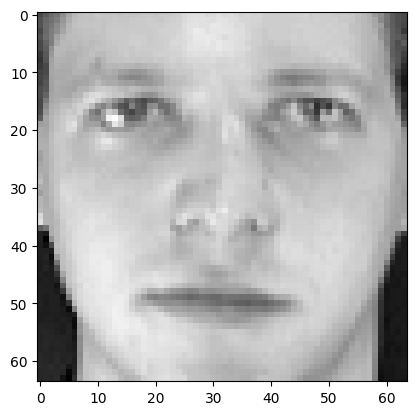

(1, 2, 64, 64)


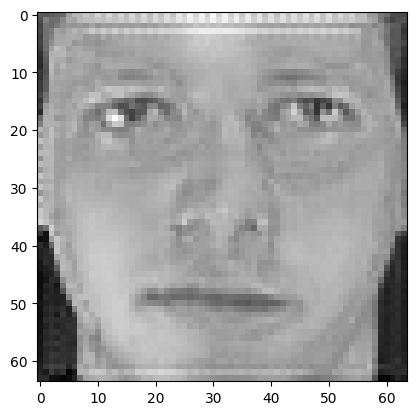

In [73]:
# Plot the first item from the dataset:
example_face = faces.data[0].reshape(64, 64)
plt.imshow(example_face, cmap="gray")
plt.show()

# Plot the reconstructed face:
denoised_face = model(torch.from_numpy(faces.data[0]).float().reshape(-1, 1, 64, 64)).detach().numpy()
print(denoised_face.shape)
plt.imshow(denoised_face[0,0,...], cmap="gray")
plt.show()
        


## History of Diffusion Models

So that's where we find ourselves in the year 2018: If we want to build a diffusion-reversing model, we iteratively apply a U-Net to our noisy image, and we can get out a pretty good denoised reconstruction. But it's SLOW! We have to run a huge U-Net to generate large images. It's time for a key insight: 

## ✨ The Key Insight ✨

**We don't need to run a U-Net to denoise an image. We can just run a U-Net to denoise a latent vector!**

This key insight is (among others) the core, critical, transformative idea behind latent diffusion: As far as the neural network is concerned, there's no difference between denoising an image, like we did above, and denoising any other vector. So why waste all our time running a thicc U-Net on an image when we have a perfectly good way of reducing the dimensionality of an image into a latent vector that is much, much smaller?

![image](https://user-images.githubusercontent.com/693511/216769571-1d8f3e84-a8f2-4e9b-a57b-3d5933784ea8.png)


## Our Grand Architecture

We've now implemented nearly all of the model components that go into a Latent Diffusion model: 

* We have an autoencoder that takes an image and converts it to a latent representation, and the reverse. 
* We have a U-Net that takes a latent representation WITH noise, and converts it to a latent representation WITHOUT noise, reversing the diffusion process.


You'll notice there's a piece of this puzzle missing: we haven't written the "Text Encoder" model yet! Luckily, neither have the authors of the stable diffusion paper: there's no reason to re-train a text encoder from scratch, because there are perfectly good pre-trained text encoders out there. So we'll just use one of those. (If this makes you feel like we've cheated, I'd encourage you to try writing a "text encoder" to condition the model after this notebook by training a one-hot encoder of image-class on a simpler dataset; it requires a LOT of data to get dependable results for a proper language model, which is why it's out of scope for this notebook. If you still feel cheated out of a cool text encoder, just wait a few weeks... We'll get there!)



In [119]:
class LatentUNet(pl.LightningModule):
    def __init__(self, vector_size= 64*64, depth=4):
        """
        A U net that operates on latents, so it uses linear layers instead of convolutions.
        """
        self.vector_size = vector_size

        def _down_layer(in_ch, out_ch):
            return nn.Sequential(
                nn.Linear(in_ch, out_ch),
                nn.ReLU(),
                nn.Linear(out_ch, out_ch),
                nn.ReLU(),
            )
        
        def _up_layer(in_ch, out_ch):
            return nn.Sequential(
                nn.Linear(in_ch, out_ch),
                nn.ReLU(),
                nn.Linear(out_ch, out_ch),
                nn.ReLU(),
            )

        super(LatentUNet, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        v = vector_size
        for i in range(depth):
            self.downs.append(_down_layer(v, v//2))
            v = v//2

        for i in range(depth):
            self.ups.append(_up_layer(v, v*2))
            v = v*2

        self.last_layer = nn.Linear(v, vector_size)

    def forward(self, x):
        x = x.reshape(-1, self.vector_size)
        for down in self.downs:
            x = down(x)
        for up in self.ups:
            x = up(x)
        output = self.last_layer(x)
        return output.reshape(-1, self.vector_size)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, x.reshape(-1, 64*64))
        self.log("train_loss", loss)
        return loss
    

In [122]:
# Generate a few new faces from scratch, and show that we can achieve 
# not-totally-awful results on our latent diffusion model that we trained in
# only a few minutes.

class LatentDiffusionToy(pl.LightningModule):
    def __init__(self, embedder, denoiser, lr=1e-3):
        super(LatentDiffusionToy, self).__init__()
        self.embedder = embedder
        self.denoiser = denoiser
        self.lr = lr

    def forward(self, x):
        # Embed the image:
        x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
        latent = self.embedder.encoder(x)
        # Denoise the latent:
        denoised_latent = self.denoiser(latent)
        # Decode the denoised latent:
        return self.embedder.decoder(denoised_latent)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE))
        self.log("train_loss", loss)
        return loss

    def sample(self, latent=None):
        if latent is None:
            latent = torch.randn(1, 256)
        assert latent.shape[1:] == (256,)
        return self.embedder.decoder(latent)

In [123]:
# Out model's pieces:
denoiser = LatentUNet(256)
# Image-to-latent net:
embedder = autoencoder # make sure you ran the cells above :)

# Train it!
model = LatentDiffusionToy(embedder, denoiser)
trainer = pl.Trainer(max_epochs=10, accelerator="gpu", devices=1)
trainer.fit(model, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type           | Params
--------------------------------------------
0 | embedder | LitAutoEncoder | 8.8 M 
1 | denoiser | LatentUNet     | 263 K 
--------------------------------------------
9.1 M     Trainable params
0         Non-trainable params
9.1 M     Total params
36.434    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


When we train, we read an image from the training set, and then run it through the ENCODER of the AE to get a latent. We then run it through the U-net to denoise (for time's sake, we only run this through once, but in "real life" this is done iteratively MANY times!). Finally, we take the denoised latent and run it through the decoder to get an image.

When we SAMPLE (see below), we take a random vector that is the right size for the latent space, and we run it through the U-net to denoise it. Then we run it through the decoder to get an image. No source image, but we still get a pretty good image out!

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
for i in range(3):
    axs[i].imshow(model.sample().detach().numpy()[0, 0, ...], cmap="gray")
    

## Quiz time! 

- GANs suffer from mode collapse (when the generator learns a mapping from the latent space to the output space that collapses multiple input points to a single output point, resulting in the generator producing only a small set of outputs). Why doesn't LD suffer from the same problem?
- All of the faces we generated seemed kinda similar. Why do you think our model consistently outputs similar-looking faces? What could we do to our architecture to increase the degrees of freedom?
- Ask a LLM (e.g., https://chat.openai.com/chat) to explain what stable diffusion is, in simple terms. What does it get right? What does it get wrong? Were you able to use a LLM such as Copilot to write any of the models in this notebook? Why do you think it fails or succeeds at the tasks you gave it?